Loaded 136 vehicle traces. Example ids: ['veh_0', 'veh_1', 'veh_10', 'veh_100', 'veh_101']
VU id: veh_0
CoV ids: ['veh_1', 'veh_10', 'veh_100']
Trace length: 60
Training LSTM predictor...
Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0335 - val_loss: 2.0054e-04
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6360e-04 - val_loss: 1.3658e-04
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1900e-04 - val_loss: 9.9688e-05
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1005e-05 - val_loss: 7.8103e-05
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6170e-05 - val_loss: 6.8470e-05
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
LSTM scaled MSE on test: 0.000071


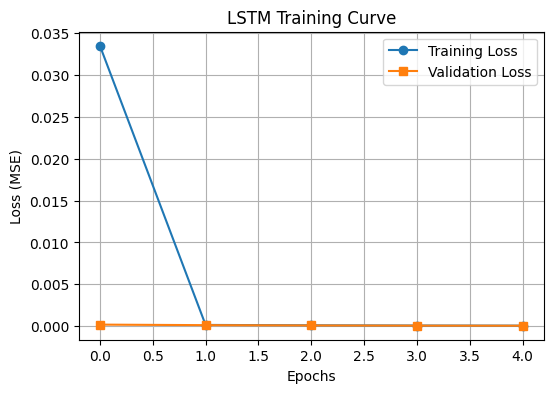

✅ LSTM model saved as lstm_mobility_predictor.h5
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training PPO agent...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 36       |
| time/              |          |
|    fps             | 4        |
|    iterations      | 1        |
|    time_elapsed    | 498      |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50.2     |
|    ep_rew_mean     | 36.3     |
| time/              |          |
|    fps             | 1        |
|    iterations      | 1        |
|    time_elapsed    | 1475     |
|    total_timesteps | 4096     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50.2     |
|    ep_rew_mean     | 37.4     |
| time/            

KeyboardInterrupt: 

In [2]:
"""
Full pipeline with real SUMO CSV traces:
- Load mobility_traces.csv and build traces dict
- Train LSTM mobility predictor (Member E)
- Use LSTM in Gym env to provide predicted CoV positions to DRL state (Member F)
- Train PPO agent to choose which CoV's data to request

Before running (one-time install):
pip install scikit-learn tensorflow stable-baselines3 gym pandas matplotlib
# In Jupyter/Colab prefix with !
"""

# -------------- Imports --------------
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import gym
from gym import spaces
from stable_baselines3 import PPO
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

# -------------- Config --------------
SEQ_LEN = 8          # lookback window length for LSTM
NUM_COV = 3          # number of candidate CoVs (change based on your CSV)
LSTM_EPOCHS = 5
PPO_TIMESTEPS = 1000
RANDOM_SEED = 42
CSV_PATH = "mobility_traces.csv"   # <--- path to your SUMO CSV file

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


# -------------- Load traces from CSV --------------
def load_traces_from_csv(csv_path, seq_len, min_len=None, time_col='time',
                         id_col='veh_id', x_col='x', y_col='y', use_cumulative=True,
                         enforce_equal_length=True, trim_to=None):
    """
    Load mobility CSV and return traces dict {veh_id: np.array(positions)}.
    Each value is a 1D array of scalar positions.
    """
    df = pd.read_csv(csv_path)
    if min_len is None:
        min_len = seq_len + 50

    df = df[[time_col, id_col, x_col, y_col]].dropna(subset=[time_col, id_col, x_col])
    df = df.sort_values([id_col, time_col])

    traces = {}
    for vid, g in df.groupby(id_col):
        g = g.sort_values(time_col)
        xs = g[x_col].values.astype(float)
        ys = g[y_col].values.astype(float)

        if use_cumulative:
            deltas = np.sqrt(np.diff(xs, prepend=xs[0])**2 + np.diff(ys, prepend=ys[0])**2)
            seq = np.cumsum(deltas)
        else:
            seq = xs

        if len(seq) >= min_len:
            traces[str(vid)] = seq

    if len(traces) == 0:
        raise ValueError("No vehicle trace long enough. Check CSV or reduce min_len.")

    if enforce_equal_length:
        if trim_to is None:
            trim_to = min(len(v) for v in traces.values())
        for k in traces.keys():
            traces[k] = traces[k][:trim_to]

    return traces


# Load CSV traces
traces = load_traces_from_csv(CSV_PATH, seq_len=SEQ_LEN)
veh_ids = list(traces.keys())
print(f"Loaded {len(veh_ids)} vehicle traces. Example ids: {veh_ids[:5]}")

# Choose 1 VU + NUM_COV CoVs
if len(veh_ids) < (1 + NUM_COV):
    raise ValueError(f"Not enough vehicles in CSV for VU + {NUM_COV} CoVs.")
vu_id = veh_ids[0]
cov_ids = veh_ids[1:1+NUM_COV]
print("VU id:", vu_id)
print("CoV ids:", cov_ids)

TOTAL_TIMESTEPS = len(next(iter(traces.values())))
print("Trace length:", TOTAL_TIMESTEPS)


# -------------- Prepare data for LSTM --------------
def build_dataset_from_traces(traces, seq_len):
    X, y = [], []
    for pos_arr in traces.values():
        for i in range(len(pos_arr) - seq_len - 1):
            seq = pos_arr[i:i+seq_len]
            target = pos_arr[i+seq_len]
            X.append(seq)
            y.append(target)
    return np.array(X), np.array(y)

X_raw, y_raw = build_dataset_from_traces(traces, SEQ_LEN)

scaler = MinMaxScaler()
all_positions = np.concatenate([traces[k] for k in traces])
scaler.fit(all_positions.reshape(-1,1))

X_scaled = scaler.transform(X_raw.reshape(-1,1)).reshape(-1, SEQ_LEN, 1)
y_scaled = scaler.transform(y_raw.reshape(-1,1)).reshape(-1,1)

split_idx = int(0.9 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


# -------------- LSTM Model (Mobility Predictor) --------------
def make_lstm(seq_len):
    model = Sequential([
        LSTM(64, input_shape=(seq_len,1)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm = make_lstm(SEQ_LEN)
print("Training LSTM predictor...")
history = lstm.fit(
    X_train, y_train,
    epochs=LSTM_EPOCHS,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

pred_test = lstm.predict(X_test)
mse = mean_squared_error(y_test, pred_test)
print(f"LSTM scaled MSE on test: {mse:.6f}")

# Plot LSTM training curve
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Training Loss", marker="o")
plt.plot(history.history["val_loss"], label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("LSTM Training Curve")
plt.legend()
plt.grid(True)
plt.savefig("lstm_training_curve.png")
plt.show()

# Save LSTM model
lstm.save("lstm_mobility_predictor.h5")
print("✅ LSTM model saved as lstm_mobility_predictor.h5")

# Function for next prediction
def predict_next_pos(raw_seq):
    x = np.array(raw_seq).reshape(-1,1)
    x_scaled = scaler.transform(x).reshape(1, SEQ_LEN, 1)
    p_scaled = lstm.predict(x_scaled, verbose=0)[0,0]
    p = scaler.inverse_transform([[p_scaled]])[0,0]
    return float(p)


# -------------- Gym Environment with Predictor --------------
class V2VWithPredictorEnv(gym.Env):
    """
    State = [VU current position, predicted CoV positions..., CoV delays...]
    Action = choose one CoV index
    Reward = perception_gain - alpha*delay
    """

    def __init__(self, traces, vu_id, cov_ids, seq_len=SEQ_LEN):
        super().__init__()
        self.traces = traces
        self.vu_id = vu_id
        self.cov_ids = cov_ids
        self.num_cov = len(cov_ids)
        self.seq_len = seq_len
        self.t = seq_len
        self.max_t = len(next(iter(traces.values()))) - 2
        self.observation_space = spaces.Box(low=-1e6, high=1e6,
                                            shape=(1 + 2*self.num_cov,), dtype=np.float32)
        self.action_space = spaces.Discrete(self.num_cov)
        self.base_delays = np.random.uniform(1.0, 3.0, size=self.num_cov)
        self.alpha = 0.08

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        low = self.seq_len
        high = max(low + 1, self.max_t - 100)
        self.t = np.random.randint(low, high)
        self.base_delays = np.random.uniform(1.0, 3.0, size=self.num_cov)

        obs = self._get_obs()
        return obs, {}

    def _get_obs(self):
        vu_pos = float(self.traces[self.vu_id][self.t])
        predicted = []
        for cid in self.cov_ids:
            raw_seq = self.traces[cid][self.t - self.seq_len: self.t]
            predicted.append(predict_next_pos(raw_seq))
        delays = self.base_delays.copy()
        obs = np.concatenate(([vu_pos], predicted, delays)).astype(np.float32)
        return obs

    def step(self, action):
        assert 0 <= action < self.num_cov

        true_next_positions = [float(self.traces[cid][self.t+1]) for cid in self.cov_ids]
        vu_true_next = float(self.traces[self.vu_id][self.t+1])

        chosen_true_pos = true_next_positions[action]
        perception_gain = 1.0 / (1.0 + abs(vu_true_next - chosen_true_pos))

        delay = float(self.base_delays[action])
        reward = perception_gain - self.alpha * delay

        self.t += 1
        terminated = self.t >= self.max_t
        truncated = False
        obs = self._get_obs()
        info = {'perception_gain': perception_gain, 'delay': delay}
        return obs, float(reward), terminated, truncated, info


# -------------- Train PPO Agent --------------
env = V2VWithPredictorEnv(traces, vu_id, cov_ids, seq_len=SEQ_LEN)
model = PPO("MlpPolicy", env, verbose=1, seed=RANDOM_SEED)

print("Training PPO agent...")
reward_log = []
for i in range(10):   # break PPO training into chunks to log reward
    model.learn(total_timesteps=PPO_TIMESTEPS//10, reset_num_timesteps=False)
    
    # quick evaluation run
    obs, info = env.reset()
    ep_reward = 0.0
    for step in range(30):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        ep_reward += reward
        if terminated or truncated:
            break
    reward_log.append(ep_reward)

# Save PPO agent
model.save("ppo_v2v_agent")
print("✅ PPO agent saved as ppo_v2v_agent.zip")

# Plot PPO reward trend
plt.figure(figsize=(6,4))
plt.plot(range(1, len(reward_log)+1), reward_log, marker="o")
plt.xlabel("Evaluation Round")
plt.ylabel("Episode Reward")
plt.title("PPO Training Reward Trend")
plt.grid(True)
plt.savefig("ppo_reward_trend.png")
plt.show()

# -------------- Predicted vs Actual Trace Plot --------------
veh0 = vu_id
true_trace = traces[veh0][:60]
pred_trace = []
for i in range(SEQ_LEN, 60):
    seq = traces[veh0][i-SEQ_LEN:i]
    pred_trace.append(predict_next_pos(seq))

plt.figure(figsize=(6,4))
plt.plot(range(60), true_trace, label="True Vehicle Trace", linewidth=2)
plt.plot(range(SEQ_LEN, 60), pred_trace, label="LSTM Prediction", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Position / Feature Value")
plt.title(f"Vehicle Trace Prediction ({veh0})")
plt.legend()
plt.grid(True)
plt.savefig("veh0_prediction.png")
plt.show()

# -------------- Test Learned Policy --------------
print("\n--- Testing learned policy ---")
for ep in range(2):
    obs, info = env.reset()
    ep_reward = 0.0
    for step in range(30):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        ep_reward += reward
        if step % 10 == 0:
            print(f"ep {ep} step {step}: action {action}, reward {reward:.3f}, info {info}")
        if terminated or truncated:
            break
    print(f"Episode {ep} total reward: {ep_reward:.3f}")

print("\n✅ Done. Models trained, plots saved, and pipeline completed.")
